In [245]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
import json
from pygsp import graphs, filters, plotting
import os
import time
from tempfile import TemporaryFile
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx
from pylab import rcParams
plotting.BACKEND = 'matplotlib'
%matplotlib inline

In [2]:
with open("../scraper/data/players_ref.json", "r") as in_file:
    players_ref_list = json.load(in_file)

In [3]:
len(players_ref_list)

12075

In [4]:
def parsePlayer(player_ref):    
    playerID = player_ref.split("/")[-1]
    
    with open("../scraper/data/players/" + playerID + "/page.html") as in_file:
        player_page = json.load(in_file)
    
    response = BeautifulSoup(player_page, 'html.parser')
    
    playerInfos = str(response.find("table", {"class":"auflistung"}))
    player = {}
    player["href"] = player_ref
    try:
        player["number"] = response.find("span", {"class":"dataRN"}).text
    except:
        player["number"] = None
    player["name"] = response.find("h1", {"itemprop":"name"}).text
    player["player_id"] = player_ref.split("/")[-1]
    position = BeautifulSoup(playerInfos.split("Position")[1], 'html.parser').find("td").text
    reg = re.compile( "[a-zA-Z -]")
    player["position"] = "".join(reg.findall(position))
    try:
        player["birthdate"] = BeautifulSoup(playerInfos.split("Date of birth")[1], 'html.parser').find("td").text
    except:
        player["birthdate"] = None
    player["nationality"] = BeautifulSoup(playerInfos.split("Nationality")[1], 'html.parser').find("td").find("img")["title"]
    player["current_club"] = BeautifulSoup(playerInfos.split("Current club")[1], 'html.parser').find("td").find_all("a")[-1].text

    try:
        transfers = []
        trans = response.find("div",{"class" : "box transferhistorie"}).find("table").find("tbody").find_all("tr", {"class":"zeile-transfer"})

        for t in trans:
            transfer = {}
            transfer["player"] = player_ref.split("/")[-1]
            transfer["date"] = t.find_all("td", {"class":"zentriert hide-for-small"})[1].text
            transfer["from"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[0].find("a")["id"]
            transfer["to"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[1].find("a")["id"]
            if (t.find("td", {"class":"zelle-abloese"}).text) == "End of loan" or t.find("td", {"class":"zelle-abloese"}).text =="Loan":
                transfer["fee"] = t.find("td", {"class":"zelle-mw"}).text
            else:
                transfer["fee"] = t.find("td",{"class":"zelle-abloese"}).text
            transfers.append(transfer)
    except:
        transfers = None
        
    return player, transfers

### Data exploration
We want to cast the fee of transfer from string to int. All currencies are expressed in euros <br/>
Mill. is used for millions <br/>
Th. is used for thousands <br/>
\- or ? is used to mark missing entry <br/>
Free Transfer is used to mark 0 value <br/>
Loan fee:amount is used to mark the value under a loan <br/>

In [5]:
missing_fees = 0
# This function will transform the fees of a player from a string to a number so that it can be used as a weight for the edges
def fix_fee(player_fee):
    # missing_fees is to count the number of 
    global missing_fees
    try:
        player_fee = player_fee.replace(":",": ").replace(",",".")
    except:
        pass
    if re.search(r'\d+.\d+', player_fee) is not None:
        fee = float(re.search(r'\d+.\d+', player_fee).group())
    else:
        fee = 0
    
    if fee > 0:
        if "Mill." in player_fee:
            processed_fee = int(fee*1000000)
        elif "Th." in player_fee:
            processed_fee = int(fee*1000)
        else:
            processed_fee = int(fee)
    else:
        missing_fees += 1
        processed_fee = 0
    
    return processed_fee

In [6]:
test = parsePlayer(players_ref_list[0])
test

({'birthdate': 'May 11, 1992 ',
  'current_club': 'Chelsea FC',
  'href': '/thibaut-courtois/profil/spieler/108390',
  'name': 'Thibaut Courtois',
  'nationality': 'Belgium',
  'number': '#13',
  'player_id': '108390',
  'position': 'Goalkeeper'},
 [{'date': 'Jun 30, 2014',
   'fee': '25,00 Mill. €',
   'from': '13',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 27, 2011',
   'fee': 'Loan fee:1,20 Mill. €',
   'from': '631',
   'player': '108390',
   'to': '13'},
  {'date': 'Jul 26, 2011',
   'fee': '8,95 Mill. €',
   'from': '1184',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 1, 2009',
   'fee': '-',
   'from': '3494',
   'player': '108390',
   'to': '1184'},
  {'date': 'Jul 1, 2008',
   'fee': '-',
   'from': '49393',
   'player': '108390',
   'to': '3494'},
  {'date': 'Jul 1, 2007',
   'fee': '-',
   'from': '34282',
   'player': '108390',
   'to': '49393'}])

## Build graph of players

In [ ]:
# compute the average number of times a player changes clubs
number_of_transfers = 0

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    number_of_transfers += len(player[1])
    
print ("The average player from our dataset has transferred {} many times".format(number_of_transfers/len(players_ref_list)))

In [26]:
with open("../scraper/data/clubs.json", "r") as in_file:
    clubs_ref_list = json.load(in_file)

In [27]:
# Multiply the number of clubs with the number of players of the first one
# This is close to the number of players we have parsed

print (len(clubs_ref_list)*len(clubs_ref_list[0]['players']))

10868


In [29]:
# We need to reduce the number of nodes to actual number of clubs. However, this will make us lose the indexing
width = len(clubs_ref_list)
print (len(clubs_ref_list))

418


In [30]:
# Our adjacency matrix should be 418x418
W = np.zeros((width,width))

In [31]:
club_ids = []
for club in clubs_ref_list:
    club_ids.append(int(club['href'].split("/")[-3]))
    
club_ids = sorted(club_ids)

There are some players that are being transfered from one club to another, with the clubs being small to the point that we shouldn't need them. If we only keep the clubs without any zero row, we would keep 7220 club. But from our previous club data, we only considered 418 clubs.
We might consider putting a constraint when adding the node. However, we would lose the index of the club. We could keep the 56089 clubs (which only depended on the id of the club) but it would lead to more computations and is not beneficial.

In [38]:
# Fill the Adjacency matrix with one when transfer from one club to another
# for player_ref in players_ref_list:
#     player = parsePlayer(player_ref)
#     print (player[0]['href'])
#     try:
#         for transfer in player[1]:
#             from_club = int(transfer["from"])
#             to_club = int(transfer["to"])
#             if(from_club in club_ids and to_club in club_ids):
#                 W[club_ids.index(from_club)][club_ids.index(to_club)] = 1
#                 W[club_ids.index(to_club)][club_ids.index(from_club)] = 1
#     except:
#         pass

/thibaut-courtois/profil/spieler/108390
/willy-caballero/profil/spieler/19948
/eduardo/profil/spieler/34159
/matej-delac/profil/spieler/60220
/david-luiz/profil/spieler/46741
/antonio-rudiger/profil/spieler/86202
/andreas-christensen/profil/spieler/196948
/gary-cahill/profil/spieler/27511
/marcos-alonso/profil/spieler/112515
/abdul-rahman-baba/profil/spieler/224884
/kenedy/profil/spieler/281404
/cesar-azpilicueta/profil/spieler/57500
/davide-zappacosta/profil/spieler/173859
/wallace-oliveira/profil/spieler/181779
/ngolo-kante/profil/spieler/225083
/tiemoue-bakayoko/profil/spieler/182618
/cesc-fabregas/profil/spieler/8806
/danny-drinkwater/profil/spieler/73491
/eden-hazard/profil/spieler/50202
/charly-musonda-jr-/profil/spieler/177862
/willian/profil/spieler/52769
/pedro/profil/spieler/65278
/victor-moses/profil/spieler/59866
/alvaro-morata/profil/spieler/128223
/diego-costa/profil/spieler/44779
/michy-batshuayi/profil/spieler/179184
/david-de-gea/profil/spieler/59377
/sergio-romero/pro

/charlie-daniels/profil/spieler/61819
/brad-smith/profil/spieler/175745
/rhoys-wiggins/profil/spieler/42298
/adam-smith/profil/spieler/61841
/simon-francis/profil/spieler/13573
/lewis-cook/profil/spieler/249089
/dan-gosling/profil/spieler/44983
/harry-arter/profil/spieler/55742
/andrew-surman/profil/spieler/29975
/emerson-hyndman/profil/spieler/223047
/ryan-fraser/profil/spieler/146795
/junior-stanislas/profil/spieler/87672
/marc-pugh/profil/spieler/36939
/jordon-ibe/profil/spieler/195652
/connor-mahoney/profil/spieler/287528
/joshua-king/profil/spieler/91059
/benik-afobe/profil/spieler/110858
/callum-wilson/profil/spieler/123682
/jermain-defoe/profil/spieler/3875
/lys-mousset/profil/spieler/291422
/tom-heaton/profil/spieler/34130
/nick-pope/profil/spieler/192080
/anders-lindegaard/profil/spieler/22491
/adam-legzdins/profil/spieler/43858
/ben-mee/profil/spieler/74810
/james-tarkowski/profil/spieler/173504
/kevin-long/profil/spieler/111114
/charlie-taylor/profil/spieler/195633
/stephen-

/deandre-yedlin/profil/spieler/255916
/javier-manquillo/profil/spieler/162029
/jesus-gamez/profil/spieler/29055
/mikel-merino/profil/spieler/338424
/jack-colback/profil/spieler/61644
/isaac-hayden/profil/spieler/206225
/jonjo-shelvey/profil/spieler/71292
/mohamed-diame/profil/spieler/70950
/matt-ritchie/profil/spieler/92469
/henri-saivet/profil/spieler/51540
/christian-atsu/profil/spieler/186997
/rolando-aarons/profil/spieler/258188
/jacob-murphy/profil/spieler/199527
/ayoze-perez/profil/spieler/246968
/dwight-gayle/profil/spieler/196522
/aleksandar-mitrovic/profil/spieler/51152
/joselu/profil/spieler/81999
/mathew-ryan/profil/spieler/128969
/tim-krul/profil/spieler/33027
/niki-maenpaa/profil/spieler/12359
/lewis-dunk/profil/spieler/148153
/shane-duffy/profil/spieler/119269
/uwe-hunemeier/profil/spieler/10503
/connor-goldson/profil/spieler/163656
/markus-suttner/profil/spieler/31514
/gaetan-bong/profil/spieler/36291
/ezequiel-schelotto/profil/spieler/119164
/ales-mateju/profil/spieler/

/simone-missiroli/profil/spieler/35747
/francesco-cassata/profil/spieler/301236
/luca-mazzitelli/profil/spieler/226025
/davide-frattesi/profil/spieler/394300
/davide-biondini/profil/spieler/22186
/antonino-ragusa/profil/spieler/102470
/nicholas-pierini/profil/spieler/372720
/domenico-berardi/profil/spieler/177843
/matteo-politano/profil/spieler/165895
/diego-falcinelli/profil/spieler/119115
/alessandro-matri/profil/spieler/40660
/gianluca-scamacca/profil/spieler/315867
/simone-scuffet/profil/spieler/238993
/albano-bizzarri/profil/spieler/7797
/davide-borsellini/profil/spieler/395075
/danilo/profil/spieler/32816
/bram-nuytinck/profil/spieler/104597
/gabriele-angella/profil/spieler/86793
/igor-bubnjic/profil/spieler/187090
/pawel-bochniewicz/profil/spieler/248395
/samir/profil/spieler/255744
/giuseppe-pezzella/profil/spieler/336960
/ali-adnan/profil/spieler/261611
/silvan-widmer/profil/spieler/168989
/jens-stryger-larsen/profil/spieler/69646
/valon-behrami/profil/spieler/21905
/simone-po

/marten-de-roon/profil/spieler/133179
/remo-freuler/profil/spieler/148252
/bryan-cristante/profil/spieler/199248
/nicolas-haas/profil/spieler/192638
/joao-schmidt/profil/spieler/198859
/leonardo-spinazzola/profil/spieler/118689
/josip-ilicic/profil/spieler/80351
/jasmin-kurtic/profil/spieler/85825
/riccardo-orsolini/profil/spieler/368482
/papu-gomez/profil/spieler/20005
/andrea-petagna/profil/spieler/199258
/andreas-cornelius/profil/spieler/203412
/luca-vido/profil/spieler/264514
/emiliano-viviano/profil/spieler/24316
/christian-puggioni/profil/spieler/48003
/andrea-tozzo/profil/spieler/57657
/gianmarco-ferrari/profil/spieler/277167
/vasco-regini/profil/spieler/72274
/matias-silvestre/profil/spieler/20003
/joachim-andersen/profil/spieler/260827
/ivan-strinic/profil/spieler/39799
/dodo/profil/spieler/109038
/nicola-murru/profil/spieler/171399
/jacopo-sala/profil/spieler/96806
/bartosz-bereszynski/profil/spieler/144143
/lucas-torreira/profil/spieler/318077
/dennis-praet/profil/spieler/12

/kenny-tete/profil/spieler/206746
/rafael/profil/spieler/61892
/lucas-tousart/profil/spieler/353948
/jordan-ferri/profil/spieler/118284
/pape-cheikh/profil/spieler/336828
/tanguy-ndombele/profil/spieler/450936
/clement-grenier/profil/spieler/72479
/houssem-aouar/profil/spieler/395693
/nabil-fekir/profil/spieler/203496
/memphis-depay/profil/spieler/167850
/willem-geubbels/profil/spieler/463620
/maxwel-cornet/profil/spieler/234781
/bertrand-traore/profil/spieler/131996
/mariano-diaz/profil/spieler/225020
/myziane-maolida/profil/spieler/371142
/amine-gouiri/profil/spieler/418659
/yoan-cardinale/profil/spieler/241231
/walter-benitez/profil/spieler/296802
/simon-pouplin/profil/spieler/24105
/malang-sarr/profil/spieler/344596
/marlon/profil/spieler/273236
/maxime-le-marchand/profil/spieler/60558
/dante/profil/spieler/16136
/gautier-lloris/profil/spieler/249636
/racine-coly/profil/spieler/323379
/romain-perraud/profil/spieler/318523
/arnaud-souquet/profil/spieler/111058
/christophe-jallet/pro

/gabriel/profil/spieler/435338
/oswaldo-vizcarrondo/profil/spieler/55237
/mory-kone/profil/spieler/157494
/johann-obiang/profil/spieler/254358
/charles-traore/profil/spieler/394906
/mathieu-deplagne/profil/spieler/127128
/jeremy-cordoval/profil/spieler/106225
/francois-bellugou/profil/spieler/75282
/alois-confais/profil/spieler/292820
/karim-azamoum/profil/spieler/275361
/tristan-dingome/profil/spieler/126683
/samuel-grandsir/profil/spieler/432772
/bryan-pele/profil/spieler/170938
/stephane-darbion/profil/spieler/14951
/saif-eddine-khaoui/profil/spieler/270411
/chaouki-ben-saada/profil/spieler/5597
/benjamin-nivet/profil/spieler/33927
/adama-niane/profil/spieler/253842
/hyun-jun-suk/profil/spieler/129990
/jonathan-tinhan/profil/spieler/120760
/raphael-caceres/profil/spieler/154169
/mamadou-sissako/profil/spieler/250038
/danijel-subasic/profil/spieler/27941
/diego-benaglio/profil/spieler/1667
/seydou-sy/profil/spieler/333694
/loic-badiashile/profil/spieler/342202
/kamil-glik/profil/spie

/lemouya-goudiaby/profil/spieler/468929
/cafu/profil/spieler/203655
/florent-mollet/profil/spieler/222859
/renaud-cohade/profil/spieler/18955
/vincent-thill/profil/spieler/316760
/mathieu-dossevi/profil/spieler/77828
/opa-nguette/profil/spieler/205587
/yann-jouffre/profil/spieler/12508
/ablie-jallow/profil/spieler/366045
/brian-fernandez/profil/spieler/267676
/nolan-roux/profil/spieler/81460
/emmanuel-riviere/profil/spieler/61637
/ibrahima-niane/profil/spieler/490417
/regis-gurtner/profil/spieler/39918
/jean-christophe-bouet/profil/spieler/110116
/raphael-adiceam/profil/spieler/419996
/prince-gouano/profil/spieler/171410
/mathieu-bodmer/profil/spieler/27305
/khaled-adenon/profil/spieler/39174
/danilo-avelar/profil/spieler/140748
/bakaye-dibassy/profil/spieler/410059
/julien-ielsch/profil/spieler/18702
/oualid-el-hajjam/profil/spieler/283127
/issa-cissokho/profil/spieler/183494
/guy-ngosso/profil/spieler/126924
/sekou-baradji/profil/spieler/23890
/bongani-zungu/profil/spieler/240892
/th

/jesus-hernandez/profil/spieler/123487
/tiago-caeiro/profil/spieler/172137
/juanto-ortuno/profil/spieler/213875
/jose-moreira/profil/spieler/13216
/luis-ribeiro/profil/spieler/118319
/thierry-graca/profil/spieler/312739
/lucao/profil/spieler/270191
/rafik-halliche/profil/spieler/67815
/goncalo-brandao/profil/spieler/14195
/pedro-monteiro/profil/spieler/339559
/thiago-cardoso/profil/spieler/114932
/joel/profil/spieler/255238
/abner/profil/spieler/273455
/fernando-fonseca/profil/spieler/344392
/mano/profil/spieler/48703
/charalampos-kyriakou/profil/spieler/203970
/pepe/profil/spieler/258018
/duarte-valente/profil/spieler/529731
/wesley/profil/spieler/520456
/lucas-evangelista/profil/spieler/270188
/eduardo/profil/spieler/220722
/andre-claro/profil/spieler/86804
/victor-andrade/profil/spieler/203323
/matheus-indio/profil/spieler/288498
/jorman-aguilar/profil/spieler/189521
/aylton-boa-morte/profil/spieler/352811
/allano-lima/profil/spieler/376441
/tocantins/profil/spieler/346767
/kleber/p

/diogo-sousa/profil/spieler/517699
/tomas-podstawski/profil/spieler/182718
/jose-semedo/profil/spieler/33710
/jacob/profil/spieler/470960
/nene-bonilha/profil/spieler/180271
/andre-pedrosa/profil/spieler/372478
/costinha/profil/spieler/236886
/joao-teixeira/profil/spieler/182710
/rafinha/profil/spieler/205022
/willyan/profil/spieler/198974
/joao-amaral/profil/spieler/352898
/yannick-djalo/profil/spieler/43845
/vasco-costa/profil/spieler/352925
/goncalo-paciencia/profil/spieler/181547
/edinho/profil/spieler/29366
/allef/profil/spieler/517669
/giorgi-makaridze/profil/spieler/55977
/jhonatan/profil/spieler/212216
/felipe-garcia/profil/spieler/52953
/andre-micael/profil/spieler/158397
/iago-santos/profil/spieler/332220
/mohamed-abarhoun/profil/spieler/209993
/hicham-belkaroui/profil/spieler/233750
/joao-sousa/profil/spieler/351977
/ruben-lima/profil/spieler/58965
/bruno-silva/profil/spieler/405833
/pierre-sagna/profil/spieler/127031
/koffi-kouao/profil/spieler/481513
/alfa-semedo/profil/sp

/oussama-assaidi/profil/spieler/57275
/adnane-tighadouini/profil/spieler/185570
/luciano-slagveer/profil/spieler/187298
/nikola-gjorgjev/profil/spieler/237673
/isaac-buckley-ricketts/profil/spieler/332323
/dylan-george/profil/spieler/406891
/tom-boere/profil/spieler/124863
/jari-oosterwijk/profil/spieler/250471
/marko-kvasina/profil/spieler/240778
/bram-castro/profil/spieler/13283
/harm-zeinstra/profil/spieler/75221
/michael-brouwer/profil/spieler/231650
/dries-wuytens/profil/spieler/83951
/robin-propper/profil/spieler/202788
/dario-van-den-buijs/profil/spieler/235274
/bart-van-hintum/profil/spieler/57328
/jeff-hardeveld/profil/spieler/263555
/roland-baas/profil/spieler/241375
/wout-droste/profil/spieler/71082
/tim-breukers/profil/spieler/63356
/joey-pelupessy/profil/spieler/187293
/sebastian-jakubiak/profil/spieler/124084
/tim-van-de-berg/profil/spieler/447827
/lerin-duarte/profil/spieler/92842
/peter-van-ooijen/profil/spieler/123521
/reuven-niemeijer/profil/spieler/443308
/jamiro-mon

/dico-koppers/profil/spieler/111184
/kingsley-ehizibue/profil/spieler/272812
/bram-van-polen/profil/spieler/41583
/rick-dekker/profil/spieler/299121
/ryan-thomas/profil/spieler/203357
/erik-israelsson/profil/spieler/76085
/erik-bakker/profil/spieler/56628
/bas-van-wijnen/profil/spieler/411454
/mustafa-saymak/profil/spieler/166959
/wouter-marinus/profil/spieler/206744
/youness-mokhtar/profil/spieler/83946
/terell-ondaan/profil/spieler/187598
/younes-namli/profil/spieler/227039
/athanasios-karagounis/profil/spieler/105811
/piotr-parzyszek/profil/spieler/155202
/stef-nijland/profil/spieler/57087
/robert-zwinkels/profil/spieler/33671
/indy-groothuizen/profil/spieler/241389
/tim-coremans/profil/spieler/119061
/wilfried-kanon/profil/spieler/163663
/tom-beugelsdijk/profil/spieler/151494
/thomas-meissner/profil/spieler/72505
/nick-kuipers/profil/spieler/159032
/aaron-meijers/profil/spieler/56836
/bas-kuipers/profil/spieler/187188
/tyronne-ebuehi/profil/spieler/309944
/trevor-david/profil/spiel

/vangelis-ikonomou/profil/spieler/33031
/giannis-kargas/profil/spieler/242758
/jerome-guihoata/profil/spieler/283566
/dimitrios-stavropoulos/profil/spieler/402970
/ehsan-haji-safi/profil/spieler/77547
/georgios-saramantas/profil/spieler/295755
/valentinos-vlachos/profil/spieler/68441
/athanasios-papageorgiou/profil/spieler/34296
/manolis-siopis/profil/spieler/182688
/panagiotis-korbos/profil/spieler/16375
/kevin-tapoko/profil/spieler/192526
/angelos-piniotis/profil/spieler/365258
/kyriakos-savvidis/profil/spieler/274858
/konstantinos-plegas/profil/spieler/241207
/masoud-shojaei/profil/spieler/26574
/srdjan-spiridonovic/profil/spieler/124774
/georgios-masouras/profil/spieler/329517
/lazaros-lamprou/profil/spieler/292356
/spyros-glynos/profil/spieler/524207
/gerasimos-voukelatos/profil/spieler/393230
/samed-yesil/profil/spieler/95295
/fiorin-durmishaj/profil/spieler/331672
/dimitrios-kyriakidis/profil/spieler/34284
/luigi-cennamo/profil/spieler/17232
/angelos-stamatopoulos/profil/spieler

/pavlos-kyriakidis/profil/spieler/295696
/emmanuel-mensah/profil/spieler/286181
/javier-umbides/profil/spieler/87381
/theodoros-vasilakakis/profil/spieler/69576
/amr-warda/profil/spieler/237641
/georgios-manousos/profil/spieler/79286
/thomas-vasiliou/profil/spieler/421224
/abiola-dauda/profil/spieler/69651
/nicolas-diguiny/profil/spieler/81588
/michalis-bastakos/profil/spieler/343120
/markos-vellidis/profil/spieler/27583
/konstantinos-peristeridis/profil/spieler/160893
/serafim-giannikoglou/profil/spieler/266203
/theodoros-venetikidis/profil/spieler/457961
/themistoklis-tzimopoulos/profil/spieler/34204
/theodoros-berios/profil/spieler/129699
/alexios-michail/profil/spieler/67071
/apostolos-skondras/profil/spieler/96813
/konstantinos-mavropanos/profil/spieler/415912
/fonsi-nadales/profil/spieler/94781
/michalis-boukouvalas/profil/spieler/52390
/alexandros-apostolopoulos/profil/spieler/188588
/nikolaos-karanikas/profil/spieler/160831
/chrysovalantis-kozoronis/profil/spieler/236785
/andi-

/kevin-ruegg/profil/spieler/290032
/adrian-winter/profil/spieler/59681
/fabian-rohner/profil/spieler/451483
/maren-haile-selassie/profil/spieler/421807
/marco-schonbachler/profil/spieler/47528
/roberto-rodriguez/profil/spieler/68021
/antonio-marchesano/profil/spieler/150963
/izer-aliu/profil/spieler/404028
/raphael-dwamena/profil/spieler/254290
/michael-frey/profil/spieler/147043
/moussa-kone/profil/spieler/364239
/dzengis-cavusevic/profil/spieler/68287
/stephen-odey/profil/spieler/491890
/jonas-omlin/profil/spieler/247915
/david-zibung/profil/spieler/4914
/simon-enzler/profil/spieler/237664
/reto-ziegler/profil/spieler/9915
/stefan-knezevic/profil/spieler/293247
/lucas/profil/spieler/190314
/marvin-schulz/profil/spieler/168678
/yannick-schmid/profil/spieler/291896
/nicolas-schindelholz/profil/spieler/65287
/claudio-lustenberger/profil/spieler/20093
/silvan-sidler/profil/spieler/342063
/christian-schwegler/profil/spieler/4931
/simon-grether/profil/spieler/159299
/hekuran-kryeziu/profil

/sime-vrsaljko/profil/spieler/76061
/juanfran/profil/spieler/16635
/thomas/profil/spieler/230784
/koke/profil/spieler/74229
/saul-niguez/profil/spieler/148928
/augusto-fernandez/profil/spieler/39151
/gabi/profil/spieler/22969
/yannick-carrasco/profil/spieler/140776
/nico-gaitan/profil/spieler/75442
/angel-correa/profil/spieler/266807
/antoine-griezmann/profil/spieler/125781
/kevin-gameiro/profil/spieler/27389
/luciano-vietto/profil/spieler/214316
/fernando-torres/profil/spieler/7767
/sergio-asenjo/profil/spieler/51710
/andres-fernandez/profil/spieler/57522
/mariano-barbosa/profil/spieler/30749
/ruben-semedo/profil/spieler/197602
/victor-ruiz/profil/spieler/62920
/alvaro-gonzalez/profil/spieler/183647
/daniele-bonera/profil/spieler/5856
/jaume-costa/profil/spieler/65318
/adrian-marin/profil/spieler/295414
/mario-gaspar/profil/spieler/73250
/antonio-rukavina/profil/spieler/27924
/bruno-soriano/profil/spieler/44412
/rodrigo-hernandez/profil/spieler/357565
/manu-trigueros/profil/spieler/18

/daniel-carrico/profil/spieler/37712
/nicolas-pareja/profil/spieler/41281
/sergio-escudero/profil/spieler/93935
/lionel-carole/profil/spieler/11530
/sebastien-corchia/profil/spieler/102744
/gabriel-mercado/profil/spieler/45319
/steven-nzonzi/profil/spieler/73734
/johannes-geis/profil/spieler/89650
/guido-pizarro/profil/spieler/105899
/ever-banega/profil/spieler/12249
/michael-krohn-dehli/profil/spieler/18006
/franco-vazquez/profil/spieler/76163
/ganso/profil/spieler/67920
/pablo-sarabia/profil/spieler/74230
/joaquin-correa/profil/spieler/227081
/nolito/profil/spieler/70934
/borja-lasso/profil/spieler/268949
/jesus-navas/profil/spieler/15956
/walter-montoya/profil/spieler/267420
/luis-muriel/profil/spieler/119228
/wissam-ben-yedder/profil/spieler/146854
/neto/profil/spieler/111819
/jaume-domenech/profil/spieler/227805
/ezequiel-garay/profil/spieler/35939
/jeison-murillo/profil/spieler/131102
/gabriel-paulista/profil/spieler/149498
/ruben-vezo/profil/spieler/257851
/jose-gaya/profil/spie

/javi-martinez/profil/spieler/44017
/sebastian-rudy/profil/spieler/57051
/niklas-dorsch/profil/spieler/251302
/thiago/profil/spieler/60444
/arturo-vidal/profil/spieler/37666
/corentin-tolisso/profil/spieler/190393
/franck-ribery/profil/spieler/22068
/james-rodriguez/profil/spieler/88103
/fabian-benko/profil/spieler/337027
/kingsley-coman/profil/spieler/243714
/arjen-robben/profil/spieler/4360
/thomas-muller/profil/spieler/58358
/robert-lewandowski/profil/spieler/38253
/kwasi-okyere-wriedt/profil/spieler/154819
/peter-gulacsi/profil/spieler/57071
/yvon-mvogo/profil/spieler/147051
/fabio-coltorti/profil/spieler/10250
/philipp-kohn/profil/spieler/251322
/dayot-upamecano/profil/spieler/344695
/willi-orban/profil/spieler/93740
/marvin-compper/profil/spieler/9340
/ibrahima-konate/profil/spieler/357119
/marcel-halstenberg/profil/spieler/70243
/bernardo/profil/spieler/364258
/lukas-klostermann/profil/spieler/215599
/benno-schmitz/profil/spieler/160968
/diego-demme/profil/spieler/82070
/stefan-

/martin-hinteregger/profil/spieler/85789
/jeffrey-gouweleeuw/profil/spieler/106405
/kevin-danso/profil/spieler/263236
/marvin-friedrich/profil/spieler/196231
/jan-ingwer-callsen-bracker/profil/spieler/3851
/christoph-janker/profil/spieler/14977
/tim-rieder/profil/spieler/111277
/philipp-max/profil/spieler/111275
/konstantinos-stafylidis/profil/spieler/148967
/kilian-jakob/profil/spieler/324760
/daniel-opare/profil/spieler/65781
/georg-teigl/profil/spieler/81698
/raphael-framberger/profil/spieler/146163
/rani-khedira/profil/spieler/124410
/daniel-baier/profil/spieler/4018
/gojko-kacar/profil/spieler/28683
/moritz-leitner/profil/spieler/82243
/jan-moravek/profil/spieler/63022
/ja-cheol-koo/profil/spieler/91841
/caiuby/profil/spieler/54137
/erik-thommy/profil/spieler/156779
/jonathan-schmid/profil/spieler/70285
/marcel-heller/profil/spieler/32207
/sergio-cordova/profil/spieler/377387
/michael-gregoritsch/profil/spieler/120205
/marco-richter/profil/spieler/279009
/alfred-finnbogason/profil

/lewis-holtby/profil/spieler/55508
/aaron-hunt/profil/spieler/4687
/filip-kostic/profil/spieler/161011
/tatsuya-ito/profil/spieler/381248
/mats-kohlert/profil/spieler/288067
/andre-hahn/profil/spieler/42783
/nicolai-muller/profil/spieler/39426
/bakery-jatta/profil/spieler/415194
/bobby-wood/profil/spieler/72519
/luca-waldschmidt/profil/spieler/196095
/sven-schipplock/profil/spieler/52530
/jann-fiete-arp/profil/spieler/343337
/torles-knoll/profil/spieler/284737
/ron-robert-zieler/profil/spieler/21327
/alexander-meyer/profil/spieler/76158
/jens-grahl/profil/spieler/40034
/benjamin-pavard/profil/spieler/353366
/timo-baumgartl/profil/spieler/187491
/holger-badstuber/profil/spieler/54659
/marcin-kaminski/profil/spieler/129358
/emiliano-insua/profil/spieler/45599
/dennis-aogo/profil/spieler/19354
/ailton/profil/spieler/283863
/andreas-beck/profil/spieler/31182
/santiago-ascacibar/profil/spieler/423436
/ebenezer-ofori/profil/spieler/262597
/matthias-zimmermann/profil/spieler/86848
/dzenis-bur

/mehdi-bourabia/profil/spieler/131731
/vedat-bora/profil/spieler/216598
/ismail-guven/profil/spieler/209240
/deni-milosevic/profil/spieler/168163
/lebogang-manyama/profil/spieler/160434
/musa-araz/profil/spieler/147037
/moryke-fofana/profil/spieler/240497
/omer-ali-sahiner/profil/spieler/110695
/abdou-traore/profil/spieler/42941
/imoh-ezekiel/profil/spieler/216463
/malick-evouna/profil/spieler/254254
/patrick-friday-eze/profil/spieler/221118
/johannes-hopf/profil/spieler/110941
/nihat-sahin/profil/spieler/179454
/taha-cengiz-demirtas/profil/spieler/185795
/numan-soysal/profil/spieler/357066
/sergey-politevich/profil/spieler/67855
/luccas-claro/profil/spieler/175179
/ousmane-ndiaye/profil/spieler/93736
/mert-cetin/profil/spieler/391498
/omer-alper-tatlisu/profil/spieler/421319
/ugur-ciftci/profil/spieler/172163
/alper-uludag/profil/spieler/55524
/halil-ibrahim-pehlivan/profil/spieler/291760
/ahmet-oguz/profil/spieler/291758
/zeki-yavru/profil/spieler/98131
/orhan-sam/profil/spieler/1012

/mahmut-nigiz/profil/spieler/454972
/selcuk-sahin/profil/spieler/7025
/mehmet-enes-ozturk/profil/spieler/410831
/andre-castro/profil/spieler/58267
/prince-segbefia/profil/spieler/170919
/rajko-rotman/profil/spieler/100303
/doganay-kilic/profil/spieler/270576
/tayfur-bingol/profil/spieler/184440
/halil-akbunar/profil/spieler/212229
/erol-hakan-sepil/profil/spieler/470739
/oscar-scarione/profil/spieler/47011
/axel-ngando/profil/spieler/170478
/serkan-bakan/profil/spieler/416626
/yoan-gouffran/profil/spieler/23825
/muhammed-enes-durmus/profil/spieler/314215
/nabil-ghilas/profil/spieler/193515
/omer-sismanoglu/profil/spieler/50774
/adis-jahovic/profil/spieler/98536
/remy-riou/profil/spieler/18940
/ufuk-ceylan/profil/spieler/29631
/haydar-yilmaz/profil/spieler/145025
/ismail-unal/profil/spieler/511117
/georgios-tzavellas/profil/spieler/42942
/welinton/profil/spieler/95152
/darko-lazic/profil/spieler/168952
/birol-parlak/profil/spieler/114400
/mamadou-fofana/profil/spieler/402004
/fabrice-ns

/giorgi-shelia/profil/spieler/58971
/aleksey-nikitin/profil/spieler/106536
/catalin-carp/profil/spieler/213016
/jimmy-tabidze/profil/spieler/250907
/denis-tumasyan/profil/spieler/38810
/pavel-alikin/profil/spieler/25879
/bojan-jokic/profil/spieler/44317
/dmitri-zhivoglyadov/profil/spieler/178335
/aleksandr-sukhov/profil/spieler/48557
/veroljub-salatic/profil/spieler/9934
/ivan-paurevic/profil/spieler/31868
/azamat-zaseev/profil/spieler/211025
/vladimir-zubarev/profil/spieler/157227
/ivan-oblyakov/profil/spieler/419845
/igor-bezdenezhnykh/profil/spieler/235732
/ondrej-vanek/profil/spieler/134578
/dmitri-stotskiy/profil/spieler/124700
/nikolay-safronidi/profil/spieler/60206
/slytm/profil/spieler/102043
/dmitri-sysuev/profil/spieler/72171
/kehinde-fatai/profil/spieler/73951
/vyacheslav-krotov/profil/spieler/187460
/islamnur-abdulavov/profil/spieler/285242
/dmitri-arapov/profil/spieler/217754
/yaroslav-godzyur/profil/spieler/48514
/gregor-balazic/profil/spieler/70869
/dominik-dinga/profil/

/vladimir-dyadyun/profil/spieler/56637
/artur-nigmatullin/profil/spieler/70074
/dmitri-khomich/profil/spieler/27017
/denis-vambolt/profil/spieler/277221
/nikolay-zajtsev/profil/spieler/58450
/mikhail-sivakov/profil/spieler/36364
/sekou-conde/profil/spieler/288854
/dmitri-belorukov/profil/spieler/48586
/petar-zanev/profil/spieler/36235
/bryan-idowu/profil/spieler/178957
/aleksandar-miljkovic/profil/spieler/78726
/janusz-gol/profil/spieler/80941
/fegor-ogude/profil/spieler/164487
/saeid-ezatolahi/profil/spieler/249271
/pavel-komolov/profil/spieler/55541
/aleksandr-ryazantsev/profil/spieler/7252
/alikhan-shavaev/profil/spieler/192930
/sergey-balanovich/profil/spieler/78332
/felicio-brown-forbes/profil/spieler/67064
/mikhail-kostyukov/profil/spieler/275159
/ivan-melnikov/profil/spieler/395976
/mikhail-gashchenkov/profil/spieler/185026
/darko-bodul/profil/spieler/39373
/aleksey-gasilin/profil/spieler/235341
/aleksandr-salugin/profil/spieler/34602
/stanislav-prokofjev/profil/spieler/106629
/

/pylyp-budkivsky/profil/spieler/99863
/teddy-chevalier/profil/spieler/57514
/jeremy-perbet/profil/spieler/23966
/nicolas-penneteau/profil/spieler/5578
/parfait-mandanda/profil/spieler/86055
/valentin-baume/profil/spieler/331574
/joachim-imbrechts/profil/spieler/502261
/steeven-willems/profil/spieler/203539
/dorian-dessoleil/profil/spieler/182424
/martos/profil/spieler/8733
/gjoko-zajkov/profil/spieler/205849
/julien-celestine/profil/spieler/518073
/nurio-fortuna/profil/spieler/290261
/francis-nganga/profil/spieler/57196
/stergos-marinos/profil/spieler/30436
/christophe-diandy/profil/spieler/105352
/marco-ilaimaharitra/profil/spieler/205550
/gaetan-hendrickx/profil/spieler/161658
/nathan-rodes/profil/spieler/481171
/dodi-lukebakio/profil/spieler/303259
/enes-saglik/profil/spieler/120306
/cristian-benavente/profil/spieler/232859
/amara-baby/profil/spieler/108587
/clement-tainmont/profil/spieler/102679
/mamadou-fall/profil/spieler/289713
/jordan-remacle/profil/spieler/30671
/kaveh-rezaei/

/niels-de-schutter/profil/spieler/89619
/jur-schryvers/profil/spieler/250574
/ibrahima-seck/profil/spieler/209933
/victorien-angban/profil/spieler/178314
/jens-cools/profil/spieler/142929
/joachim-van-damme/profil/spieler/74544
/francois-marquet/profil/spieler/194438
/ryota-morioka/profil/spieler/140310
/nana-opoku-ampomah/profil/spieler/429086
/tuur-dierckx/profil/spieler/168158
/aleksandar-boljevic/profil/spieler/227532
/floriano-vanzo/profil/spieler/201696
/olivier-myny/profil/spieler/316406
/isaac-thelin/profil/spieler/201311
/ronnie-schwartz/profil/spieler/46007
/ryan-mmaee/profil/spieler/249543
/cherif-ndiaye/profil/spieler/480705
/sinan-bolat/profil/spieler/33862
/antonijo-jezina/profil/spieler/52524
/kevin-debaty/profil/spieler/59633
/jelle-van-damme/profil/spieler/4323
/dino-arslanagic/profil/spieler/110660
/moustapha-sall/profil/spieler/43886
/dylan-batubinsika/profil/spieler/289432
/steve-colpaert/profil/spieler/20296
/alexander-corryn/profil/spieler/129580
/matheus/profil/s

/volodymyr-priyomov/profil/spieler/34773
/vladyslav-khomutov/profil/spieler/435665
/moha/profil/spieler/316280
/ilya-mikhalev/profil/spieler/167032
/stanislav-bilenky/profil/spieler/511669
/evgen-past/profil/spieler/49016
/roman-lyopka/profil/spieler/345750
/nazar-malinovskyi/profil/spieler/381812
/oleksandr-zozulya/profil/spieler/483718
/taras-kacharaba/profil/spieler/213975
/dmytro-fateev/profil/spieler/271635
/maksym-kovalyov/profil/spieler/58402
/oleksandr-matkobozhyk/profil/spieler/468735
/cece-franck-pepe/profil/spieler/289434
/ivan-tsyupa/profil/spieler/271228
/arman-hovhannisyan/profil/spieler/192192
/marc-castells/profil/spieler/73137
/igor-zagalsky/profil/spieler/271665
/maksym-drachenko/profil/spieler/202840
/artem-favorov/profil/spieler/170245
/arnaud-guedj/profil/spieler/476072
/pavlo-polegenko/profil/spieler/216579
/bruninho/profil/spieler/483451
/oleksiy-zbun/profil/spieler/405176
/maksym-averyanov/profil/spieler/363065
/kyrylo-dryshliuk/profil/spieler/501417
/maksym-pry

/milan-havel/profil/spieler/261913
/radim-reznik/profil/spieler/62794
/tomas-horava/profil/spieler/70153
/patrik-hrosovsky/profil/spieler/217879
/ales-cermak/profil/spieler/147540
/diego-zivulic/profil/spieler/148545
/jan-kopic/profil/spieler/119103
/milan-petrzela/profil/spieler/21101
/martin-zeman/profil/spieler/62570
/jan-kovarik/profil/spieler/81800
/vaclav-pilar/profil/spieler/63955
/andreas-ivanschitz/profil/spieler/2923
/daniel-kolar/profil/spieler/43246
/michael-krmencik/profil/spieler/178469
/jakub-reznicek/profil/spieler/59772
/marek-bakos/profil/spieler/74935
/stanislav-dostal/profil/spieler/82477
/zdenek-zlamal/profil/spieler/43243
/milan-svenger/profil/spieler/63748
/zoran-gajic/profil/spieler/70328
/ondrej-baco/profil/spieler/431058
/tomas-janicek/profil/spieler/26885
/robert-matejov/profil/spieler/113009
/lukas-bartosak/profil/spieler/145821
/milos-kopecny/profil/spieler/333492
/libor-holik/profil/spieler/323903
/josef-hnanicek/profil/spieler/180558
/petr-jiracek/profil/

/ondrej-karafiat/profil/spieler/181614
/matej-hybs/profil/spieler/137621
/milan-kerbr/profil/spieler/82143
/vladimir-coufal/profil/spieler/157672
/jan-mikula/profil/spieler/178467
/lukas-vacha/profil/spieler/36063
/ji%C5%99i-kulhanek/profil/spieler/292522
/radim-breite/profil/spieler/94172
/petr-sevcik/profil/spieler/147555
/filip-havelka/profil/spieler/318099
/daniel-bartl/profil/spieler/109541
/zdenek-folprecht/profil/spieler/90969
/milos-bosancic/profil/spieler/37276
/tomas-malinsky/profil/spieler/193590
/matej-pulkrab/profil/spieler/256097
/roman-potocny/profil/spieler/179240
/martin-graiciar/profil/spieler/319176
/radek-voltr/profil/spieler/113159
/vlastimil-hruby/profil/spieler/157578
/roman-vales/profil/spieler/95805
/michal-barta/profil/spieler/70126
/adam-richter/profil/spieler/469277
/ludek-pernica/profil/spieler/147099
/marek-kysela/profil/spieler/124557
/martin-kouril/profil/spieler/261958
/matej-hanousek/profil/spieler/267473
/jaroslav-zeleny/profil/spieler/142219
/petr-ry

/gustavo-blanco/profil/spieler/374855
/capixaba/profil/spieler/435253
/robinho/profil/spieler/15511
/luan/profil/spieler/192318
/marlone/profil/spieler/231039
/clayton/profil/spieler/250007
/fred/profil/spieler/31005
/rafael-moura/profil/spieler/53256
/fabio/profil/spieler/22415
/rafael/profil/spieler/68097
/lucao/profil/spieler/401528
/lucas-franca/profil/spieler/418615
/manoel/profil/spieler/113586
/leotm/profil/spieler/55245
/dede/profil/spieler/113094
/digao/profil/spieler/85942
/murilo-cerqueira/profil/spieler/458710
/arthur/profil/spieler/517518
/diogo-barbosa/profil/spieler/167724
/bryan/profil/spieler/224863
/rafael-galhardo/profil/spieler/124701
/ezequiel/profil/spieler/224047
/john-lennon/profil/spieler/156252
/henrique/profil/spieler/54303
/lucas-romero/profil/spieler/242201
/lucas-silva/profil/spieler/218118
/hudson/profil/spieler/54257
/nonoca/profil/spieler/520994
/alejandro-cabral/profil/spieler/53472
/giorgian-de-arrascaeta/profil/spieler/248410
/thiago-neves/profil/spi

/wellington-simiao/profil/spieler/186886
/bryan-uruena/profil/spieler/214269
/juan/profil/spieler/7336
/marquinhos/profil/spieler/97
/caio-cesar/profil/spieler/347823
/toshi/profil/spieler/366448
/pedro-castro/profil/spieler/214312
/luan-pereira/profil/spieler/527394
/lourenco/profil/spieler/515068
/maurinho/profil/spieler/221437
/romulo/profil/spieler/349515
/willians/profil/spieler/68845
/junior-dutra/profil/spieler/99615
/joel/profil/spieler/184928
/diego-alves/profil/spieler/42373
/alex-muralha/profil/spieler/277743
/cesar/profil/spieler/177776
/thiago-da-silva/profil/spieler/294817
/gabriel-batista/profil/spieler/401535
/rever/profil/spieler/72489
/rhodolfo/profil/spieler/55322
/rafael-vaz/profil/spieler/255805
/juan/profil/spieler/1599
/leo-duarte/profil/spieler/312678
/rene/profil/spieler/212209
/miguel-trauco/profil/spieler/177690
/para/profil/spieler/76100
/rodinei/profil/spieler/185966
/kleber/profil/spieler/323868
/willian-arao/profil/spieler/210747
/romulo/profil/spieler/14

/rodrigo-ramos/profil/spieler/372377
/geovane/profil/spieler/471994
/vitor-carvalho-vieira/profil/spieler/553062
/jonas/profil/spieler/346870
/joao-paulo/profil/spieler/112239
/alan-santos/profil/spieler/113336
/edinho/profil/spieler/27363
/ricardo-gomes/profil/spieler/48845
/anderson/profil/spieler/31645
/matheus-galdezani/profil/spieler/378975
/tomas-bastos/profil/spieler/349161
/thiago-lopes/profil/spieler/393835
/yantm/profil/spieler/469136
/tiago-real/profil/spieler/99516
/rafael-longuine/profil/spieler/214527
/alexander-baumjohann/profil/spieler/16474
/daniel/profil/spieler/296912
/iago/profil/spieler/443239
/leo-santos/profil/spieler/450193
/getterson/profil/spieler/446043
/rildo/profil/spieler/175230
/kleber/profil/spieler/15880
/henrique-almeida/profil/spieler/103743
/alecsandro/profil/spieler/44131
/neto-berola/profil/spieler/109652
/keirrison/profil/spieler/68821
/yilmar-filigrana/profil/spieler/260387
/artur-moraes/profil/spieler/20394
/elias/profil/spieler/479211
/luiz-fel

/edson-alvarez/profil/spieler/401356
/miguel-samudio/profil/spieler/73644
/osmar-mares/profil/spieler/53562
/paul-aguilar/profil/spieler/52606
/gil-buron/profil/spieler/298675
/luis-amador/profil/spieler/471097
/javier-guemez/profil/spieler/164749
/jose-daniel-guerrero/profil/spieler/55349
/osvaldo-martinez/profil/spieler/73630
/michel-garcia/profil/spieler/124734
/luis-amador/profil/spieler/472324
/cristhian-paredes/profil/spieler/401728
/carlos-rosel/profil/spieler/357558
/rubens-sambueza/profil/spieler/26268
/william-da-silva/profil/spieler/53365
/brian-lozano/profil/spieler/338889
/michael-arroyo/profil/spieler/45874
/cecilio-dominguez/profil/spieler/273012
/diego-lainez/profil/spieler/371174
/renato-ibarra/profil/spieler/191830
/manuel-perez/profil/spieler/221406
/oribe-peralta/profil/spieler/53563
/silvio-romero/profil/spieler/88082
/carlos-darwin-quintero/profil/spieler/55666
/martin-zuniga/profil/spieler/233940
/jesus-moreno/profil/spieler/193475
/alfonso-sanchez/profil/spieler

/guillermo-rojas/profil/spieler/55404
/kevin-gutierrez/profil/spieler/234011
/betsiel-hernandez/profil/spieler/234951
/george-corral/profil/spieler/103889
/jonathan-bornstein/profil/spieler/39454
/jaime-gomez/profil/spieler/244724
/mario-osuna/profil/spieler/135867
/marco-jimenez/profil/spieler/67470
/nery-dominguez/profil/spieler/267413
/aldo-arellano/profil/spieler/500994
/neri-cardozo/profil/spieler/19955
/luis-miguel-noriega/profil/spieler/55386
/armando-zamorano/profil/spieler/185623
/yerson-candelo/profil/spieler/158333
/ricardo-esqueda/profil/spieler/66825
/luis-gil/profil/spieler/131177
/edgar-benitez/profil/spieler/90147
/camilo-sanvezzo/profil/spieler/172285
/carlos-fierro/profil/spieler/185365
/edgar-lugo/profil/spieler/53183
/andres-renteria/profil/spieler/233007
/angel-sepulveda/profil/spieler/160700
/jordi-cortizo/profil/spieler/430021
/emanuel-villa/profil/spieler/54022
/patricio-rubio/profil/spieler/216800
/paolo-yrizar/profil/spieler/426654
/cristian-campestrini/profil

/hiram-munoz/profil/spieler/463162
/greg-garza/profil/spieler/118318
/damian-perez/profil/spieler/71106
/kevin-gutierrez/profil/spieler/234011
/john-requejo/profil/spieler/346645
/carlos-vargas/profil/spieler/508257
/juan-carlos-nunez/profil/spieler/58597
/jose-maduena/profil/spieler/162947
/juan-pablo-meza/profil/spieler/261172
/guido-rodriguez/profil/spieler/342385
/luis-telles/profil/spieler/129418
/alejandro-guido/profil/spieler/189883
/juninho/profil/spieler/85363
/juan-carlos-medina/profil/spieler/53023
/joe-corona/profil/spieler/162940
/jorge-ortiz/profil/spieler/55212
/luis-chavez/profil/spieler/331059
/paul-arriola/profil/spieler/189876
/victor-malcorra/profil/spieler/87518
/aviles-hurtado/profil/spieler/148713
/alonso-escoboza/profil/spieler/193344
/gonzalo-diaz/profil/spieler/103096
/hector-villalba/profil/spieler/237061
/matias-pisano/profil/spieler/139923
/amando-moreno/profil/spieler/253573
/juan-martin-lucero/profil/spieler/162807
/dayro-moreno/profil/spieler/42457
/gabr

/jorge-sanchez/profil/spieler/209460
/michel-garcia/profil/spieler/124734
/jesus-isijara/profil/spieler/103790
/alejandro-vela/profil/spieler/54020
/jonas-aguirre/profil/spieler/149436
/nicolas-maturana/profil/spieler/185652
/jesus-gomez/profil/spieler/103260
/felipe-gallegos/profil/spieler/155054
/edson-puch/profil/spieler/113217
/diego-riolfo/profil/spieler/160613
/edgar-espindola/profil/spieler/59528
/claudio-riano/profil/spieler/238011
/maximiliano-barreiro/profil/spieler/119635
/alejandro-diaz/profil/spieler/295390
/rodrigo-prieto/profil/spieler/59885
/brian-rowe/profil/spieler/213545
/clement-diop/profil/spieler/190915
/jon-kempin/profil/spieler/161010
/daniel-steres/profil/spieler/227909
/michael-ciani/profil/spieler/12906
/dave-romney/profil/spieler/367552
/hugo-arellano/profil/spieler/315755
/ashley-cole/profil/spieler/3182
/robbie-rogers/profil/spieler/51352
/bradley-diallo/profil/spieler/127129
/pele-van-anholt/profil/spieler/106634
/nathan-smith/profil/spieler/189903
/jerma

/jake-mcguire/profil/spieler/482650
/richie-marquez/profil/spieler/315948
/ken-tribbett/profil/spieler/271662
/oguchi-onyewu/profil/spieler/12517
/joshua-yaro/profil/spieler/374554
/jack-elliott/profil/spieler/490362
/auston-trusty/profil/spieler/389253
/fabinho/profil/spieler/75081
/giliano-wijnaldum/profil/spieler/79121
/keegan-rosenberry/profil/spieler/268302
/raymon-gaddis/profil/spieler/213017
/aaron-jones/profil/spieler/482653
/warren-creavalle/profil/spieler/213005
/maurice-edu/profil/spieler/50987
/brian-carroll/profil/spieler/39404
/haris-medunjanin/profil/spieler/30666
/derrick-jones/profil/spieler/411554
/ilson-jr-/profil/spieler/52937
/eric-ayuk/profil/spieler/367750
/alejandro-bedoya/profil/spieler/111783
/roland-alberg/profil/spieler/64481
/adam-najem/profil/spieler/221619
/chris-pontius/profil/spieler/105993
/fabian-herbers/profil/spieler/196077
/marcus-epps/profil/spieler/482646
/c-j-sapong/profil/spieler/174724
/charlie-davies/profil/spieler/46472
/fafa-picault/profil/

/erik-hurtado/profil/spieler/255922
/kyle-greig/profil/spieler/266616
/luis-robles/profil/spieler/47289
/ryan-meara/profil/spieler/213051
/evan-louro/profil/spieler/375564
/aurelien-collin/profil/spieler/45155
/aaron-long/profil/spieler/271072
/gideon-baah/profil/spieler/265719
/damien-perrinelle/profil/spieler/57540
/fidel-escobar/profil/spieler/345716
/hassan-ndam/profil/spieler/485529
/kemar-lawrence/profil/spieler/288710
/connor-lade/profil/spieler/209845
/sal-zizzo/profil/spieler/54326
/michael-murillo/profil/spieler/354482
/tyler-adams/profil/spieler/332705
/dan-metzger/profil/spieler/253779
/felipe-martins/profil/spieler/85012
/sean-davis/profil/spieler/271184
/arun-basuljevic/profil/spieler/375561
/mike-grella/profil/spieler/103952
/dilly-duka/profil/spieler/105336
/sacha-kljestan/profil/spieler/39475
/derrick-etienne/profil/spieler/354763
/vincent-bezecourt/profil/spieler/429455
/zeiko-lewis/profil/spieler/220574
/daniel-royer/profil/spieler/74762
/muhamed-keita/profil/spieler

/camilo/profil/spieler/74286
/andres-dalessandro/profil/spieler/3445
/juan/profil/spieler/520467
/mossoro/profil/spieler/520466
/alex-santana/profil/spieler/219835
/eduardo-sasha/profil/spieler/162883
/carlos/profil/spieler/284000
/alisson-farias/profil/spieler/366645
/william-pottker/profil/spieler/199472
/diego/profil/spieler/405720
/leandro-damiao/profil/spieler/139449
/nicolas-lopez/profil/spieler/185593
/roberson/profil/spieler/91846
/joanderson/profil/spieler/294823
/joao-ricardo/profil/spieler/270420
/fernando-leal/profil/spieler/67954
/glaycon/profil/spieler/145713
/glauco/profil/spieler/265768
/jory/profil/spieler/429799
/rafael-lima/profil/spieler/54305
/messias/profil/spieler/401539
/roger/profil/spieler/429800
/lima/profil/spieler/53011
/renato-justi/profil/spieler/520489
/giovanni/profil/spieler/270650
/para/profil/spieler/323618
/norberto-neto/profil/spieler/152538
/ceara/profil/spieler/38893
/victor/profil/spieler/476335
/juninho/profil/spieler/271187
/ernandes/profil/sp

/richarlyson/profil/spieler/16159
/renato-henrique/profil/spieler/261730
/vitor-braga/profil/spieler/480229
/denner/profil/spieler/258372
/gabriel-leite/profil/spieler/394417
/fumagalli/profil/spieler/56383
/luiz-fernando/profil/spieler/410494
/betinho/profil/spieler/237851
/paulinho/profil/spieler/233536
/juninho/profil/spieler/333602
/eliandro/profil/spieler/132061
/caique/profil/spieler/371927
/elias/profil/spieler/547485
/serafim/profil/spieler/525875
/diogo-silva/profil/spieler/186398
/gabriel-leite/profil/spieler/54336
/joao-gabriel/profil/spieler/228049
/gabriel-soares/profil/spieler/547731
/neguete/profil/spieler/101680
/ernani/profil/spieler/410123
/william/profil/spieler/520459
/pierre/profil/spieler/525520
/pablo/profil/spieler/405695
/paulinho/profil/spieler/153621
/christiano/profil/spieler/124227
/moacir/profil/spieler/77624
/gabriel-passos/profil/spieler/349446
/leo-cereja/profil/spieler/435333
/kazu/profil/spieler/439651
/diego-lorenzi/profil/spieler/243835
/alaor-junio

/moises/profil/spieler/164404
/matheus/profil/spieler/552517
/oliveira/profil/spieler/269686
/matheus-cavichioli/profil/spieler/54274
/raul/profil/spieler/520093
/douglas-silva/profil/spieler/527349
/micael/profil/spieler/160142
/vinicius/profil/spieler/520650
/samuel-jesus/profil/spieler/152167
/mauricio/profil/spieler/373065
/bruno-collaco/profil/spieler/4270
/para/profil/spieler/92898
/tinga/profil/spieler/273442
/bruno-ribeiro/profil/spieler/76181
/vidal/profil/spieler/527047
/camazzola/profil/spieler/34274
/diego-felipe/profil/spieler/178935
/wanderson/profil/spieler/265659
/fahel/profil/spieler/33538
/lucas/profil/spieler/175237
/bruninho/profil/spieler/206988
/vacaria/profil/spieler/367845
/mateus-santana/profil/spieler/527046
/sananduva/profil/spieler/531064
/wallacer/profil/spieler/243527
/felipe-lima/profil/spieler/178294
/leilson/profil/spieler/178295
/juninho-silva/profil/spieler/74568
/diego-souza/profil/spieler/225695
/wesley-nata/profil/spieler/432961
/yago-cesar/profil/

/gabriel-gudino/profil/spieler/458169
/alexis-castro/profil/spieler/364602
/ruben-botta/profil/spieler/88542
/juan-cavallaro/profil/spieler/221037
/leandro-romagnoli/profil/spieler/15694
/cristian-barrios/profil/spieler/503377
/bautista-merlini/profil/spieler/431737
/ezequiel-cerutti/profil/spieler/267882
/german-berterame/profil/spieler/401572
/tomas-conechny/profil/spieler/401571
/nicolas-blandi/profil/spieler/153022
/nicolas-reniero/profil/spieler/496415
/diego-rodriguez/profil/spieler/90800
/jeremias-ledesma/profil/spieler/284342
/marcelo-mino/profil/spieler/508135
/emilio-di-fulvio/profil/spieler/487393
/jose-leguizamon/profil/spieler/389552
/fernando-tobio/profil/spieler/69802
/renzo-alfani/profil/spieler/492973
/marcelo-ortiz/profil/spieler/267772
/alfonso-parot/profil/spieler/84238
/elias-gomez/profil/spieler/302139
/paulo-ferrari/profil/spieler/30807
/mauricio-martinez/profil/spieler/309388
/leonardo-gil/profil/spieler/125907
/santiago-romero/profil/spieler/148608
/gustavo-col

/jose-san-roman/profil/spieler/45655
/juan-sills/profil/spieler/111907
/nery-leyes/profil/spieler/280204
/braian-rivero/profil/spieler/400896
/jalil-elias/profil/spieler/376859
/brian-sarmiento/profil/spieler/58319
/emiliano-franco/profil/spieler/422402
/hector-fertoli/profil/spieler/424024
/victor-figueroa/profil/spieler/40501
/mauricio-tevez/profil/spieler/334097
/joaquin-torres/profil/spieler/359233
/enzo-cabrera/profil/spieler/538527
/luis-leal/profil/spieler/158419
/mauro-guevgeozian/profil/spieler/120964
/daniel-opazo/profil/spieler/534621
/federico-lanzillota/profil/spieler/267906
/lucas-chavez/profil/spieler/360791
/maximiliano-cavalotti/profil/spieler/55862
/camilo-saiz/profil/spieler/119918
/miguel-torren/profil/spieler/19992
/leonel-mosevich/profil/spieler/407517
/sebastian-martinez/profil/spieler/76611
/agustin-alberione/profil/spieler/534035
/gonzalo-piovi/profil/spieler/284120
/guillermo-benitez/profil/spieler/421997
/enzo-ybanez/profil/spieler/534034
/jonathan-sandoval/p

/ramon-abila/profil/spieler/88049
/fernando-coniglio/profil/spieler/146929
/diego-mendoza/profil/spieler/283394
/tomas-molina/profil/spieler/429591
/alan-aguerre/profil/spieler/269784
/cesar-rigamonti/profil/spieler/76159
/gonzalo-yordan/profil/spieler/323435
/tomas-figueroa/profil/spieler/399014
/lautaro-gianetti/profil/spieler/225963
/emiliano-amor/profil/spieler/348273
/fausto-grillo/profil/spieler/323422
/mauricio-toni/profil/spieler/540299
/brian-cufre/profil/spieler/401521
/erik-jerez/profil/spieler/269796
/nicolas-tripichio/profil/spieler/275614
/matias-perez-acuna/profil/spieler/300312
/fabian-cubero/profil/spieler/26438
/santiago-caseres/profil/spieler/466298
/leandro-desabato/profil/spieler/181704
/gianluca-mancuso/profil/spieler/401581
/nicolas-dominguez/profil/spieler/497291
/lucas-robertone/profil/spieler/457221
/fabricio-alvarenga/profil/spieler/381430
/gaston-diaz/profil/spieler/68748
/matias-vargas/profil/spieler/376211
/jorge-correa/profil/spieler/96140
/agustin-doffo/

/sebastian-anchoverri/profil/spieler/459237
/matias-cahais/profil/spieler/45310
/cristian-nasuti/profil/spieler/26249
/sergio-ojeda/profil/spieler/261240
/nicolas-herranz/profil/spieler/472318
/martin-ferreyra/profil/spieler/540443
/nicolas-pantaleone/profil/spieler/282690
/cristian-villanueva/profil/spieler/88098
/pedro-silva-torrejon/profil/spieler/438927
/mauricio-rosales/profil/spieler/251619
/leandro-lacunza/profil/spieler/441381
/franco-bellocq/profil/spieler/334058
/jonathan-blanco/profil/spieler/68744
/lucas-villarruel/profil/spieler/268499
/tomas-costa/profil/spieler/55164
/lautaro-belleggia/profil/spieler/503328
/lucas-mancinelli/profil/spieler/202761
/david-vega/profil/spieler/87531
/rodrigo-cabalucci/profil/spieler/267727
/maximiliano-fornari/profil/spieler/369708
/orlando-gaona-lugo/profil/spieler/142463
/said-llambay/profil/spieler/459239
/emiliano-tellechea/profil/spieler/76821
/michael-covea/profil/spieler/359024
/franco-troyansky/profil/spieler/424673
/ramon-lentini/pr

/javier-salas/profil/spieler/228255
/edgar-zaldivar/profil/spieler/427203
/luis-robles/profil/spieler/53046
/juan-vigon/profil/spieler/234227
/clifford-aboagye/profil/spieler/262554
/ravel-morrison/profil/spieler/128907
/jose-avila/profil/spieler/549787
/fidel-martinez/profil/spieler/75612
/candido-ramirez/profil/spieler/210342
/christian-tabo/profil/spieler/227604
/bryan-garnica/profil/spieler/401311
/carlos-nava/profil/spieler/284991
/patrick-soko/profil/spieler/524197
/uvaldo-luna/profil/spieler/273909
/milton-caraglio/profil/spieler/55156
/matias-alustiza/profil/spieler/64843
/jahir-barraza/profil/spieler/174154
/alfredo-talavera/profil/spieler/50965
/luis-garcia/profil/spieler/236710
/miguel-centeno/profil/spieler/88394
/ramon-pasquel/profil/spieler/427267
/maximiliano-perg/profil/spieler/195809
/osvaldo-gonzalez/profil/spieler/76391
/carlos-calvo/profil/spieler/233916
/juan-delgadillo/profil/spieler/298676
/santiago-garcia/profil/spieler/90489
/efrain-velarde/profil/spieler/51044

/aaron-fernandez/profil/spieler/103864
/mario-de-luna/profil/spieler/67712
/igor-lichnovsky/profil/spieler/209513
/luis-omar-hernandez/profil/spieler/53323
/miguel-ponce/profil/spieler/147632
/jairo-gonzalez/profil/spieler/131066
/bryan-colula/profil/spieler/384368
/brayan-beckeles/profil/spieler/171043
/manuel-iturra/profil/spieler/40428
/xavier-baez/profil/spieler/50945
/luis-perez/profil/spieler/118646
/jesus-isijara/profil/spieler/103790
/edgar-alaffita/profil/spieler/264104
/matias-fernandez/profil/spieler/37918
/dieter-villalpando/profil/spieler/308477
/roberto-alvarado/profil/spieler/353583
/victor-davila/profil/spieler/366143
/felipe-gallegos/profil/spieler/155054
/diego-riolfo/profil/spieler/160613
/facundo-pereyra/profil/spieler/123497
/martin-barragan/profil/spieler/264126
/pablo-velazquez/profil/spieler/84282
/claudio-riano/profil/spieler/238011
/daniel-alvarez/profil/spieler/347575
/carlos-gonzalez/profil/spieler/366620
/othoniel-arce/profil/spieler/155041
/alfredo-saldiva

/sergio-romero/profil/spieler/242558
/jhon-salazar/profil/spieler/370678
/edder-farias/profil/spieler/140128
/ernesto-alvarez/profil/spieler/267950
/nicolas-vikonis/profil/spieler/74378
/ramiro-sanchez/profil/spieler/199208
/felipe-roman/profil/spieler/552474
/andres-cadavid/profil/spieler/179487
/janeiler-rivas/profil/spieler/208729
/matias-de-los-santos/profil/spieler/296445
/anier-figueroa/profil/spieler/140003
/felipe-banguero/profil/spieler/362406
/jair-palacios/profil/spieler/312919
/stiven-vega/profil/spieler/393964
/jhon-duque/profil/spieler/421009
/david-silva/profil/spieler/74071
/juan-dominguez/profil/spieler/73685
/sebastian-ayala/profil/spieler/272259
/henry-rojas/profil/spieler/76925
/jacobo-kouffaty/profil/spieler/236288
/alexis-zapata/profil/spieler/263027
/robinson-aponza/profil/spieler/84111
/elicer-quinones/profil/spieler/156569
/maximiliano-nunez/profil/spieler/83531
/harold-mosquera/profil/spieler/490621
/duvier-riascos/profil/spieler/119229
/ayron-del-valle/profil

/william-tesillo/profil/spieler/137840
/carlos-henao/profil/spieler/188393
/jose-moya/profil/spieler/253056
/javier-lopez/profil/spieler/182120
/hector-urrego/profil/spieler/233055
/leyvin-balanta/profil/spieler/209898
/juan-david-valencia/profil/spieler/72566
/dairon-mosquera/profil/spieler/255963
/carlos-arboleda/profil/spieler/179474
/victor-giraldo/profil/spieler/74517
/yeison-gordillo/profil/spieler/147670
/baldomero-perlaza/profil/spieler/172300
/sebastian-salazar/profil/spieler/355155
/juan-daniel-roa/profil/spieler/161195
/kevin-salazar/profil/spieler/421012
/omar-perez/profil/spieler/74425
/almir-soto/profil/spieler/363731
/jhon-fredy-pajoy/profil/spieler/76643
/daniel-buitrago/profil/spieler/216871
/jorge-obregon/profil/spieler/414773
/yamilson-rivera/profil/spieler/77182
/anderson-plata/profil/spieler/211399
/wilson-morelo/profil/spieler/74065
/humberto-osorio/profil/spieler/84133
/daniel-angulo/profil/spieler/243185
/damir-ceter/profil/spieler/460898
/david-gonzalez/profil/

/manuel-berrio/profil/spieler/413559
/eddie-segura/profil/spieler/459466
/ricardo-villarraga/profil/spieler/119185
/nelson-lemus/profil/spieler/123306
/elvis-perlaza/profil/spieler/74668
/marvin-vallecilla/profil/spieler/356457
/carlos-robles/profil/spieler/119914
/ronaldo-tavera/profil/spieler/413554
/jose-leudo/profil/spieler/273725
/anibal-hernandez/profil/spieler/91762
/andres-ricaurte/profil/spieler/253846
/hamilton-valencia/profil/spieler/421398
/franco-bolo/profil/spieler/440005
/mateo-figoli/profil/spieler/55332
/jackson-palacios/profil/spieler/413557
/omar-duarte/profil/spieler/384582
/edinson-palomino/profil/spieler/117872
/miguel-murillo/profil/spieler/76719
/jorge-ramos/profil/spieler/117876
/sergio-almiron/profil/spieler/144111
/cristian-canga/profil/spieler/253045
/jefferson-martinez/profil/spieler/254122
/santiago-londono/profil/spieler/240142
/santiago-jimenez/profil/spieler/474678
/sergio-mosquera/profil/spieler/262514
/santiago-ruiz-rojas/profil/spieler/422991
/andres

/ruben-castro/profil/spieler/25316
/iminjan-ilhamjan/profil/spieler/251971
/zhiquan-pang/profil/spieler/211672
/yan-wu/profil/spieler/236677
/zhixiang-wen/profil/spieler/281520
/guoming-wang/profil/spieler/251168
/qi-jin/profil/spieler/363637
/eddi-gomes/profil/spieler/161137
/ahmad-al-salih/profil/spieler/172965
/cao-gu/profil/spieler/148158
/cheng-long/profil/spieler/292763
/heng-liu/profil/spieler/316227
/heng-luo/profil/spieler/265714
/zhao-ke/profil/spieler/250207
/abduwal-ablet/profil/spieler/211372
/yao-lu/profil/spieler/240902
/kuo-yang/profil/spieler/252011
/ke-zhang/profil/spieler/156875
/jiajun-pan/profil/spieler/363239
/ziru-zhang/profil/spieler/363630
/fei-wang/profil/spieler/240914
/ye-yuan/profil/spieler/222026
/zhuoyi-feng/profil/spieler/211095
/wei-long/profil/spieler/279526
/gang-feng/profil/spieler/218240
/jinbao-zhong/profil/spieler/259686
/borek-dockal/profil/spieler/62983
/changjie-du/profil/spieler/361752
/hao-yan/profil/spieler/446845
/ricardo-vaz-te/profil/spie

/mingyu-zhao/profil/spieler/521132
/marinho/profil/spieler/74758
/jinliang-wang/profil/spieler/269736
/odion-ighalo/profil/spieler/62121
/bruno-meneghel/profil/spieler/67966
/long-tan/profil/spieler/158315
/changcheng-cheng/profil/spieler/147768
/xiaotian-shi/profil/spieler/154952
/zhenqiang-zhang/profil/spieler/236685
/qianyu-mu/profil/spieler/254193
/qinghao-xue/profil/spieler/521129
/assani-lukimya/profil/spieler/32618
/zheng-lang/profil/spieler/143792
/gaojun-wu/profil/spieler/211019
/qiang-lu/profil/spieler/156055
/shuai-yang/profil/spieler/316458
/yinghao-jiang/profil/spieler/381641
/shangkun-liu/profil/spieler/251927
/liang-wang/profil/spieler/156066
/wei-lu/profil/spieler/252260
/chen-song/profil/spieler/211679
/yanjun-zhang/profil/spieler/268997
/qiao-wang/profil/spieler/281516
/zhaoliang-sun/profil/spieler/342014
/zhenfeng-xiong/profil/spieler/281521
/ruizhen-zhang/profil/spieler/448445
/fa-wang/profil/spieler/264425
/yanqiang-hu/profil/spieler/218295
/yifei-sang/profil/spiel

/dudu/profil/spieler/432294
/koki-oshima/profil/spieler/275542
/cristiano/profil/spieler/207600
/diego-oliveira/profil/spieler/201443
/yuji-rokutan/profil/spieler/117235
/yohei-nishibe/profil/spieler/79641
/yuki-uekusa/profil/spieler/79488
/toru-takagiwa/profil/spieler/307736
/takahiro-iida/profil/spieler/486196
/freire/profil/spieler/112237
/tomoya-inukai/profil/spieler/203908
/kanu/profil/spieler/229978
/makoto-kakuda/profil/spieler/79738
/yugo-tatsuta/profil/spieler/486197
/ko-matsubara/profil/spieler/307300
/hiroshi-futami/profil/spieler/272902
/shoma-kamata/profil/spieler/114259
/taisuke-muramatsu/profil/spieler/103304
/shin-mitsuzaki/profil/spieler/420647
/kota-sugiyama/profil/spieler/83011
/chikashi-masuda/profil/spieler/27781
/yosuke-kawai/profil/spieler/110908
/ryo-takeuchi/profil/spieler/110912
/mitsunari-musaka/profil/spieler/131568
/takuma-edamura/profil/spieler/79632
/kohei-shimizu/profil/spieler/106278
/ryohei-shirasaki/profil/spieler/213488
/mitchell-duke/profil/spieler/

/masayuki-yamada/profil/spieler/428306
/kosuke-ota/profil/spieler/110911
/ryoya-ogawa/profil/spieler/353785
/sei-muroya/profil/spieler/188910
/takuji-yonemoto/profil/spieler/80874
/rei-hirakawa/profil/spieler/471154
/yojiro-takahagi/profil/spieler/106275
/kento-hashimoto/profil/spieler/183436
/sotan-tanabe/profil/spieler/113630
/yohei-kajiyama/profil/spieler/79520
/yoshitake-suzuki/profil/spieler/426662
/takahiro-yanagi/profil/spieler/407834
/wataru-sasaki/profil/spieler/275573
/jakkit-wachpirom/profil/spieler/426638
/keigo-higashi/profil/spieler/113657
/takuya-uchida/profil/spieler/432592
/lipe-veloso/profil/spieler/520858
/tasuku-hiraoka/profil/spieler/308030
/naohiro-ishikawa/profil/spieler/79519
/takefusa-kubo/profil/spieler/405398
/kensuke-nagai/profil/spieler/103305
/yoshito-okubo/profil/spieler/27439
/peter-utaka/profil/spieler/20360
/ryoichi-maeda/profil/spieler/27739
/in-soo-yu/profil/spieler/412696
/hiroki-iikura/profil/spieler/79404
/ayaki-suzuki/profil/spieler/156649
/daich

In [39]:
W.shape[0]

418

In [40]:
number_of_inner_transfers = 0
for i in range(W.shape[0]):
    if(W[i][i] == 1):
        number_of_inner_transfers += 1
        
print ("There have been {} innertransfers".format(number_of_inner_transfers))

There have been 2 innertransfers


In [41]:
# Set all the transfers within the same club to zero -> no self-loops
np.fill_diagonal(W, 0)

In [46]:
# Create a temporary matrix so we wouldn't need to recompute W if we later need to go back to our result
# np.save('adj_matrix.npy', W)

## Load directly filled matrix

In [49]:
# Load W matrix from pre-saved model
W = np.load('adj_matrix.npy')

In [50]:
# Here temp_W contains the clubs that are not necessarily from the 418 clubs we selected
print (W.shape)

(418, 418)


In [89]:
# Build graph from G
G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

418 nodes, 6714 edges


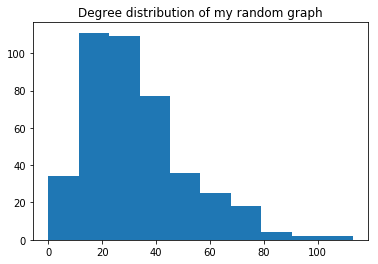

In [90]:
plt.hist(G.d)
plt.title('Degree distribution of my random graph');

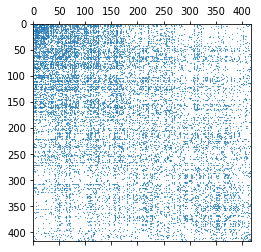

In [106]:
plt.spy(G.W, markersize=0.20)


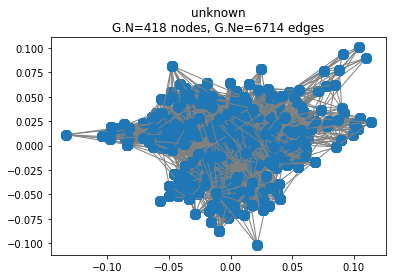

In [104]:
G.set_coordinates('spring')
plotting.plot_graph(G)

## Compute eigenvalues and eigenvectors

In [243]:
G=nx.from_numpy_matrix(W)
laplacian = nx.normalized_laplacian_matrix(G)

In [259]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(laplacian, k = 10, which = 'SM')
eigenvalues

array([  1.65951120e-17+0.j,  -1.59767181e-16+0.j,   2.26177619e-01+0.j,
         1.53788795e-16+0.j,   5.55111512e-17+0.j,  -2.64104828e-16+0.j,
         1.72501275e-17+0.j,   1.37321520e-16+0.j,   6.38401720e-17+0.j,
         5.55111512e-17+0.j])

In [261]:
print (eigenvectors.shape)

(418, 10)


/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


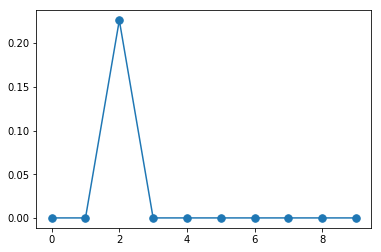

In [262]:
plt.plot(eigenvalues, '.-', markersize=15);

# Data visualization/exploration

In [198]:
nationalities = []
birthdays_month = []

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    try:
        nationalities.append(player[0]['nationality'])
        bday = player[0]["birthdate"].replace(",","").strip()
        datetime_object = datetime.strptime(bday, '%b %d %Y')
        birthdays_month.append(datetime_object.month)
    except:
        nationalities.append("N/A")
        birthdays_month.append("N/A")

In [222]:
# Sort nationalities by most common
nationalities_counter = Counter(nationalities).most_common()
index = []
iterator = 1
nationalities = []
nationalities_count = []
for nationality in nationalities_counter:
    index.append(iterator)
    iterator += 1
    nationalities.append(nationality[0])
    nationalities_count.append(nationality[1])

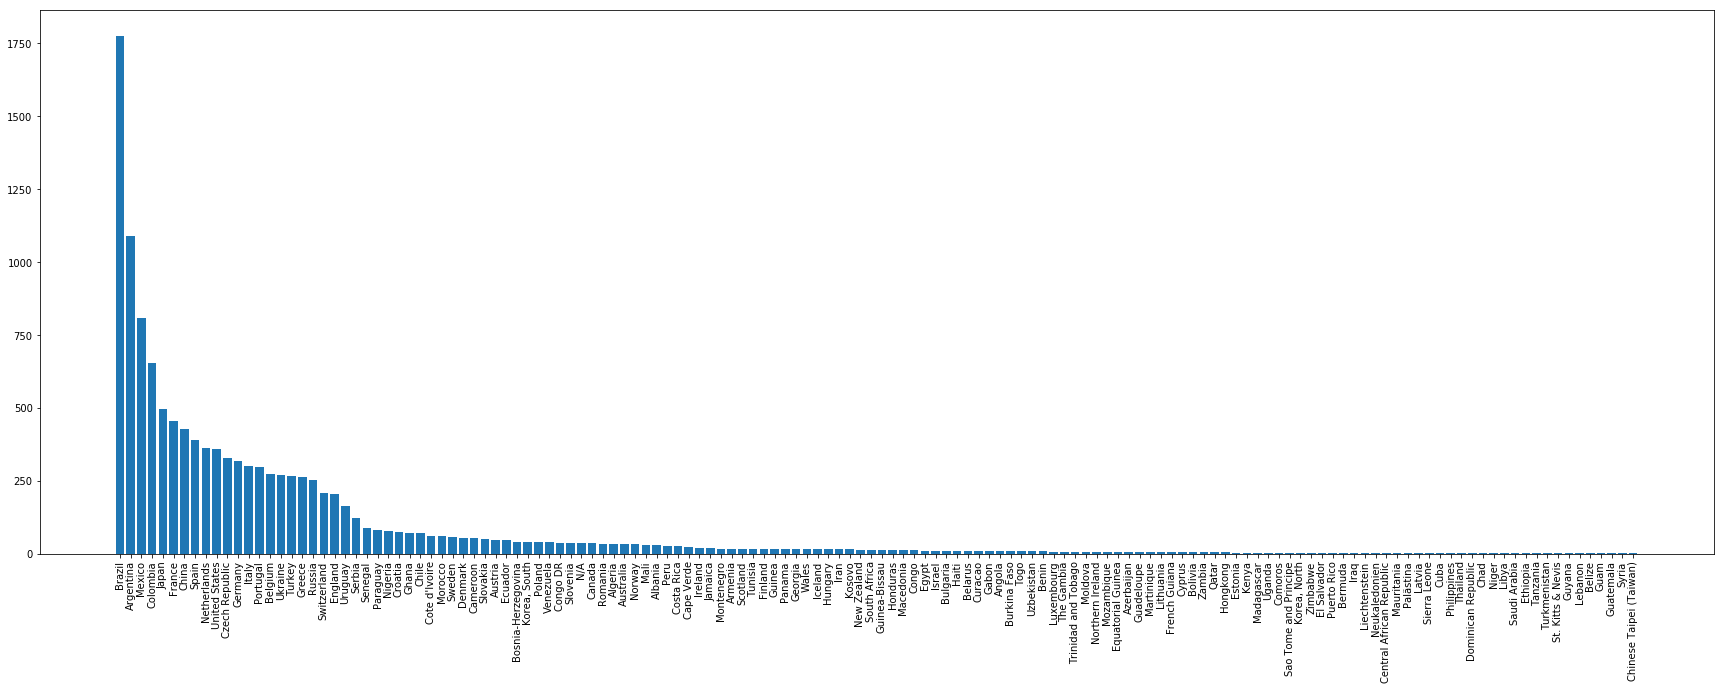

In [240]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, nationalities_count, align='center')
plt.xticks(index, nationalities,rotation=90)
plt.show()
